# Read HIV Data

In [1]:
import os
if os.getcwd().endswith('Setup'):
    os.chdir('..')

In [2]:
import NotebookImport
from Setup.Imports import *

importing IPython notebook from Setup/Imports

Populating the interactive namespace from numpy and matplotlib


### Read in Clinical Data

In [3]:
c1 = pd.read_excel(ucsd_path + 'DESIGN_Fox_v2_Samples-ChipLAyout-Clinical UNMC-UCSD methylomestudy.xlsx', 
                   'HIV- samples from OldStudy', index_col=0)
c2 = pd.read_excel(ucsd_path + 'DESIGN_Fox_v2_Samples-ChipLAyout-Clinical UNMC-UCSD methylomestudy.xlsx', 
                   'HIV+ samples', index_col=0)
clinical = c1.append(c2)
clinical['Sentrix_Position'] = clinical['Sentrix_Position\\'].map(lambda s: s[:-1])
del clinical['Sentrix_Position\\']

Update clinical data with new data provided by Howard Fox

In [4]:
age_new = pd.read_csv(ucsd_path + 'UpdatesAges-Infection.csv', index_col=0)
age = age_new.age.combine_first(clinical.age)
age.name= 'age'
clinical['age'] = age
l = 'estimated duration hiv (months)'
clinical[l] = age_new['Estimated Duration HIV+ (months)'].combine_first(clinical[l])

Clean up diabetes across annotation files

In [5]:
diabetes = clinical['diabetes'].combine_first(clinical['Diabetes @ 000'])
diabetes = diabetes.replace('N','no')
clinical['diabetes'] = diabetes
del clinical['Diabetes @ 000']
diabetes.value_counts()

no    192
dtype: int64

All of the patients are white or Caucasian

In [6]:
ethnicity = clinical.ethnicity
ethnicity = ethnicity.replace('wht','white')
ethnicity = ethnicity.replace('Caucasian - European','white')
clinical['ethnicity'] = ethnicity
ethnicity.value_counts()

white    192
dtype: int64

Sex is not recorded for the cases but they are all HIV+ men.

In [7]:
clinical['sex'] = clinical['sex'].fillna('M')

Fix BMI to unified labels

In [8]:
bmi = clinical['bmi'].combine_first(clinical['BMI'])
clinical['BMI'] = bmi
clinical = clinical[clinical.columns.difference(['bmi'])]

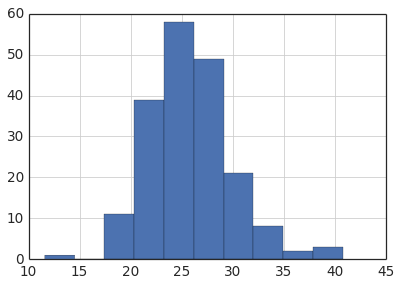

In [9]:
#Do not import
bmi.hist()

In [10]:
current_usage = ["Current 'Other' dx", 'Current Alcohol dx',
                 'Current Bipolar I', 'Current Bipolar II',
                 'Current Cannabis dx', 'Current Cocaine dx',
                 'Current Dysthymia', 'Current Halucinogen dx',
                 'Current Inhalant dx', 'Current MDD',
                 'Current Methamphetamine dx', 'Current Opioid dx',
                 'Current PCP dx', 'Current Sedative dx',
                 'Any Current Substance dx']
current_usage = clinical[current_usage]
current_usage.dropna(how='all').apply(pd.value_counts).fillna(0).T

,NO,YES
Current 'Other' dx,142,0
Current Alcohol dx,140,2
Current Bipolar I,142,0
Current Bipolar II,142,0
Current Cannabis dx,141,1
Current Cocaine dx,142,0
Current Dysthymia,142,0
Current Halucinogen dx,142,0
Current Inhalant dx,142,0
Current MDD,120,22


In [11]:
past_usage = ["LT 'Other' dx",  'LT Alcohol dx', 'LT Bipolar I', 
              'LT Bipolar II', 'LT Cannabis dx', 'LT Cocaine dx',
              'LT Dysthymia', 'LT Halucinogen dx', 'LT Inhalant dx',
              'LT MDD', 'LT Methamphetamine dx', 'LT Opioid dx',
              'LT PCP dx', 'LT Sedative dx', 'Any LT Substance dx']
past_usage = clinical[past_usage]
past_usage.dropna(how='all').apply(pd.value_counts).fillna(0).T

,NO,YES
LT 'Other' dx,141,1
LT Alcohol dx,50,92
LT Bipolar I,142,0
LT Bipolar II,142,0
LT Cannabis dx,99,43
LT Cocaine dx,112,30
LT Dysthymia,141,1
LT Halucinogen dx,123,19
LT Inhalant dx,134,8
LT MDD,58,84


#### Trimming the clinical dataset

None of the patients are diabetic

In [12]:
clinical.diabetes.value_counts()

no    192
dtype: int64

All of the patients are hepatitis C negative

In [13]:
clinical['HCV'].dropna(0).value_counts(0)

Neg    142
dtype: int64

All patients are currently using anti-retoviral therepy, but 5 patients treatment is not classified as HAART

In [14]:
clinical['ARV History'].value_counts()

Currently Using    142
dtype: int64

In [15]:
clinical['ARV Status'].value_counts()

HAART        137
non-HAART      5
dtype: int64

All patients are reported as adhererent, but a few are not 100% adherent

In [16]:
clinical['adherent'].value_counts()

Adherent    142
dtype: int64

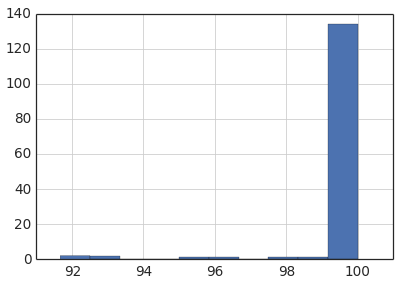

In [17]:
#Do not import
clinical['adherence %'].hist()

We have a wide varienty of regimens with 81 unique combinations of 35 drugs

In [18]:
reg = clinical['Current Regimen'].dropna().str.split('/').map(sorted)
drugs = {r for s in reg for r in s}
drug_mat = pd.DataFrame({i: {d: d in s for d in drugs} for i,s in 
                         reg.iteritems()}).T
drug_mat.sum().order()

EVG      1
TPV      1
DDC      1
DRV      2
SQV      2
APV      2
BDT      2
BSD      3
SQV2     3
DLV      4
FPV      5
T20      8
NFV      8
D4T      9
DDI     15
NVP     26
ABV     30
LPV     30
EFV     31
ZDV     35
ATV     46
FTC     52
3TC     63
RTV     82
TFV     91
dtype: int64

These can be broken down into 8 regimen types

In [19]:
clinical['Regimen Type'].value_counts()

PI/NRTI Based       69
NNRTI/NRTI Based    43
3-class             22
NRTI Based           3
PI/NNRTI Based       2
4+ class             1
NNRTI Based          1
PI Based             1
dtype: int64

In [20]:
kill_list = ['zhang id', 'diabetes', 'Methylation ID', 
             'Sentrix_ID','Sample_Plate','Sample_Well','Sentrix_Position',
             ]
drugs = ['ARV History', 'ARV Status', 'Current Regimen', 'Regimen Type',
         'adherence %' ,'adherent']

In [21]:
left = [c for c in clinical if c not in past_usage and c not in current_usage
        and c not in drugs]

In [22]:
age = clinical.age

In [23]:
clinical['BDI > 17'].value_counts()

0    91
1    51
dtype: int64

In [24]:
clinical['ARV History'].value_counts()

Currently Using    142
dtype: int64

In [25]:
clinical['CDC stage'].value_counts()

C3    57
B3    24
A2    20
A3    17
B2    14
C2     6
A1     4
dtype: int64

IADL = Instrumental activities of daily living

In [26]:
iadl = clinical.IADL
iadl.value_counts()

indep      109
dep         25
missing      8
dtype: int64

Global imparement

In [27]:
clinical['global impairment'].value_counts()

nml    74
imp    68
dtype: int64

Patient's Assessment of Own Functioning Inventory (PAOFI)

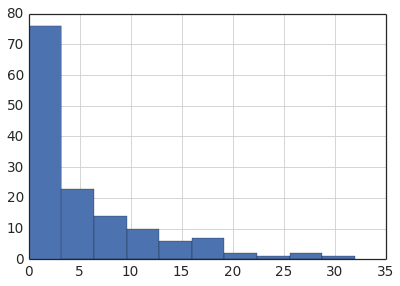

In [28]:
#Do not import
paofi = clinical['paofi total']
paofi.hist()

RPR (Rapid plasma reagin) is a diagnostic used to detect syphilis

In [29]:
clinical.RPR.value_counts()

Neg    136
Pos      6
dtype: int64

#### Batches

In [30]:
site = clinical.Site
site.value_counts()

UCSD       73
VNDRBLT    69
dtype: int64

In [31]:
clinical.Utox.value_counts()

utox neg    130
utox pos     12
dtype: int64

Beck Depression Inventory is a questionarre measuring depression levels (from [Wikipedia](http://en.wikipedia.org/wiki/Beck_Depression_Inventory))
* 0–13: minimal depression 
* 14–19: mild depression  
* 20–28: moderate depression  
* 29–63: severe depression.

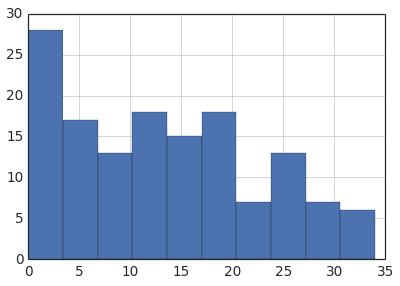

In [32]:
#Do not import
beck = clinical['beck total'].dropna()
beck.hist()

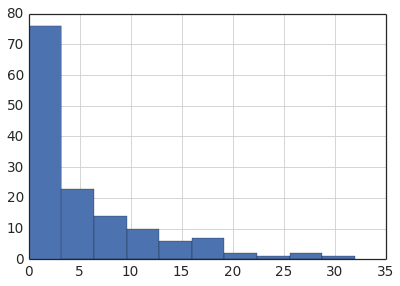

In [33]:
#Do not import
clinical['paofi total'].hist()

#### Read in lab blood work data

* abstract exam date onto exam year for anonymity

In [34]:
labs = pd.read_excel(ucsd_path + 'fox_methylation_labdata_073014.xlsx',
                     index_col=0)
labs['nb exam year']= labs['nb exam date'].map(lambda s: s.year)
del labs['nb exam date']
labs = labs.dropna(axis=1, how='all')
labs = labs.ix[labs.index.intersection(clinical.index)]

* Dropping five patients because they don't look Kosher  
* Renormalizing cell percentages because some don't sum to 100%

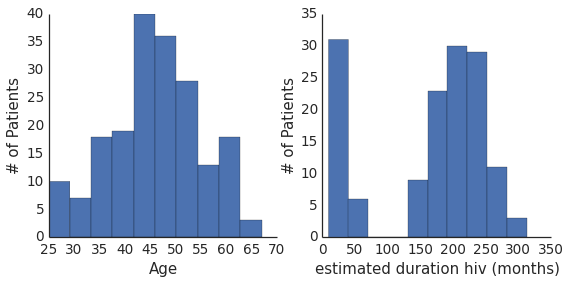

In [35]:
#Do not import
fig, axs = subplots(1,2, figsize=(9,4))
clinical.age.hist(ax=axs[0])
clinical['estimated duration hiv (months)'].hist(ax=axs[1])
axs[0].set_xlabel('Age')
axs[1].set_xlabel('estimated duration hiv (months)')
for ax in axs:
    ax.set_ylabel('# of Patients')
    prettify_ax(ax)

As can be seen above, we have two groups of patients with respect to HIV duration, we don't really have the sample size to tease apart any differences other than this main distiction so for now I am just treating duration of HIV as a categorical variable (e.g. controls, short exposure and long exposure)

In [36]:
duration = clinical['estimated duration hiv (months)']
duration = (1.*duration.notnull()) + (1.*duration > 100)
duration = duration.map({0:'Control',1:'HIV Short',2:'HIV Long'})
duration.value_counts()

HIV Long     105
Control       50
HIV Short     37
dtype: int64

### Patient Selection Criteria
* There are a couple of female patients in the controls, we are going to get rid of those as all of the cases are males  
* Most of the HIV patients are under HAART therepy, there are a few that are not and we are going to filter those out for now and possibly look at them after the primary analysis

In [37]:
duration = duration.ix[ti(clinical['ARV Status'] != 'non-HAART')]
duration = duration.ix[ti(clinical.sex != 'F')].dropna()
duration.value_counts()

HIV Long     104
Control       48
HIV Short     33
dtype: int64

### Read in HIV Methylation data  

Read in quantile-normalized data, adjusted for cellular compositions and then normalized agin using BMIQ.

In [38]:
df_hiv = pd.read_hdf('/data_ssd/methylation_norm.h5', 'quant_BMIQ_adj')

In [39]:
df_hiv = pd.read_hdf('/data_ssd/methylation_norm.h5', 'quant_BMIQ_adj')
df_hiv = df_hiv.ix[:, duration.index]
df_hiv = df_hiv.dropna(1)

Read in data processed with BMIQ using Horvath's gold standard.

In [40]:
df_hiv_n = pd.read_hdf('/data_ssd/methylation_norm.h5', 'BMIQ_Horvath')
df_hiv_n = df_hiv_n.ix[:, duration.index]
df_hiv_n = df_hiv_n.dropna(1)
df_hiv_n = df_hiv_n.groupby(level=0).first()

Adjust this data for cellular composition.  This is done after the normalization to not mess around with Horvath's pipeline too much. 

In [41]:
flow_sorted_data = pd.read_hdf('/data_ssd/methylation_annotation.h5','flow_sorted_data_horvath_norm')
cell_type = pd.read_hdf('/data_ssd/methylation_annotation.h5', 'label_map')
cell_counts = pd.read_hdf('/data_ssd/dx_methylation.h5', 'cell_counts')
cell_counts = cell_counts.groupby(level=0, axis=0).first()

In [42]:
n2 = flow_sorted_data.groupby(cell_type, axis=1).mean()
avg = n2[cell_counts.columns].dot(cell_counts.ix[df_hiv.columns].T)
d2 = df_hiv_n.ix[avg.index, df_hiv.columns].dropna(axis=[0,1], how='all')
cc = avg.ix[:, ti(duration=='Control')].mean(1)
df_hiv_n = (d2 - avg).add(cc, axis=0).dropna(how='all')

In [43]:
keepers = duration.index.intersection(df_hiv.columns.intersection(df_hiv_n.columns))
duration = duration.ix[keepers]
duration = duration.groupby(level=0).first()

In [44]:
consent = c1['zhang id'].isin([12373001,12805001,14055003,15455001]) == False
duration = duration.ix[duration.index.difference(ti(consent == False))]

In [46]:
ti(c1['zhang id'].isin([12373001,12805001,14055003,15455001]))

Index([u'METI-29', u'METI-31', u'METI-41', u'METI-43'], dtype='object')

In [45]:
duration.value_counts()

HIV Long     104
Control       42
HIV Short     33
dtype: int64

In [48]:
store = pd.HDFStore('/data_ssd/dx_methylation.h5')
study = store['study']
age = store['age']
gender = store['gender']

### Set up Probe Filters

In [49]:
detection_p = pd.read_hdf('/data_ssd/dx_methylation.h5', 'detection_p')
#detection_p = detection_p[detection_p[0] > 10e-5]
detection_p = detection_p[detection_p.Sample_Name.isin(duration.index)]

In [50]:
ff = detection_p.groupby('level_0').size() > 3
ff.value_counts()

False    33349
True     12468
dtype: int64

In [51]:
STORE = '/data_ssd/methylation_annotation.h5'
snps = pd.read_hdf(STORE, 'snps')

In [52]:
snp_near = (snps.Probe_SNPs != '')
snp_near.value_counts()

False    425620
True      59892
dtype: int64

In [53]:
probe_idx = df_hiv.index.difference(ti(ff))